In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
bola_df = pd.read_csv('bola.csv')
dynamic_df = pd.read_csv('dynamic.csv')
throughput_df = pd.read_csv('throughput.csv')

# Clean each of the CSV's

In [ ]:
for df in [throughput_df, bola_df, dynamic_df]:
    # column names
    df.columns = df.columns.str.strip().str.replace(r'[^\w]', '', regex=True)

    # each column weird quotes
    df = df.applymap(lambda x: str(x).strip().replace("'", "").replace('"', "").strip())

    # convert data types
    df['index'] = df['index'].astype(int)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['bufferLevel'] = df['bufferLevel'].astype(float)
    df['throughput'] = df['throughput'].astype(float)
    df['latency'] = df['latency'].astype(float)
    df['mode'] = df['mode'].astype(int)

/var/folders/t8/kyjn4rpd2mv2ppyrl29j0l000000gn/T/ipykernel_82950/941567019.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).strip().replace("'", "").replace('"', "").strip())
/var/folders/t8/kyjn4rpd2mv2ppyrl29j0l000000gn/T/ipykernel_82950/941567019.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).strip().replace("'", "").replace('"', "").strip())
/var/folders/t8/kyjn4rpd2mv2ppyrl29j0l000000gn/T/ipykernel_82950/941567019.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).strip().replace("'", "").replace('"', "").strip())


In [48]:
# add algorithm name to each df
throughput_df['algorithm'] = 'Throughput'
bola_df['algorithm'] = 'BOLA'
dynamic_df['algorithm'] = 'Dynamic'

In [49]:
# COMBINE THEM ALL
combined_df = pd.concat([throughput_df, bola_df, dynamic_df], ignore_index=True)

# Statistics accross different modes

In [50]:
# group by mode and algorithm
grouped = combined_df.groupby(['algorithm', 'mode'])[['bufferLevel', 'throughput', 'latency']]

# Compute mean, standard deviation, min, max, etc.
stats_by_mode = grouped.agg(['mean', 'std', 'min', 'max'])
print(stats_by_mode)

                bufferLevel                          throughput             \
                       mean       std    min    max        mean        std   
algorithm  mode                                                              
BOLA       1       1.592500  1.505416   0.00   3.88    0.357500   0.122095   
           2      12.856250  2.319405   7.75  15.74    2.966875   0.067401   
           3       1.503750  3.341180   0.00   9.47    2.720000   0.543034   
           4      12.444375  1.945974   9.57  16.48    0.991250   0.023910   
           5      14.092963  1.458676  11.85  16.40    6.644444   2.033628   
Dynamic    1       4.723750  3.170606   0.00   8.46    0.178750   0.060104   
           2      23.776875  8.270142   7.00  31.37    2.699375   0.715332   
           3       2.806250  5.068502   0.00  14.15    2.930000   0.141421   
           4      11.317500  6.675312   4.07  32.78    7.041875  23.910092   
           5      32.116296  1.523248  29.52  34.68  109.780370 

In [53]:
mean_by_mode = grouped.mean().reset_index()
print(mean_by_mode)

     algorithm  mode  bufferLevel  throughput     latency
0         BOLA     1     1.592500    0.357500  433.906250
1         BOLA     2    12.856250    2.966875   30.671875
2         BOLA     3     1.503750    2.720000   85.625000
3         BOLA     4    12.444375    0.991250   40.890625
4         BOLA     5    14.092963    6.644444   20.694444
5      Dynamic     1     4.723750    0.178750  545.281250
6      Dynamic     2    23.776875    2.699375   36.109375
7      Dynamic     3     2.806250    2.930000   66.843750
8      Dynamic     4    11.317500    7.041875   48.390625
9      Dynamic     5    32.116296  109.780370   19.037037
10  Throughput     1     4.200000    0.187500  368.781250
11  Throughput     2    22.856875    2.681250   35.453125
12  Throughput     3     3.601250    2.970000   86.468750
13  Throughput     4     9.355625    1.110000   38.781250
14  Throughput     5    14.163333    1.090000   22.851852


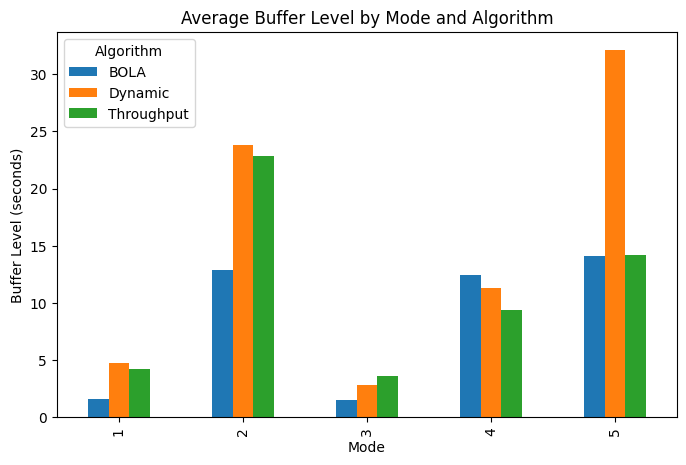

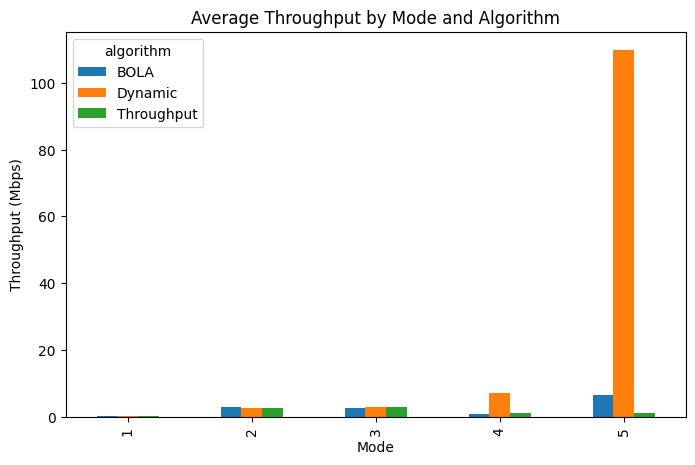

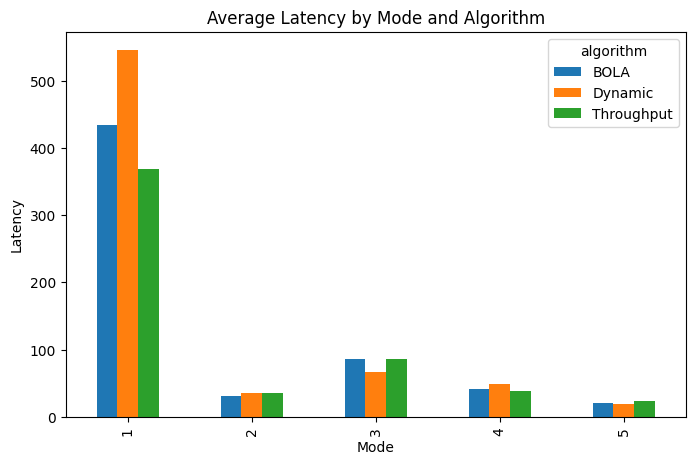

In [56]:
# Pivot the mean values to get a table shaped by 'mode' rows, 'algorithm' columns
buffer_mean = mean_by_mode.pivot(index='mode', columns='algorithm', values='bufferLevel')

# Create a bar chart
buffer_mean.plot(kind='bar', figsize=(8, 5))
plt.title('Average Buffer Level by Mode and Algorithm')
plt.xlabel('Mode')
plt.ylabel('Buffer Level (seconds)')
plt.legend(title='Algorithm')
plt.show()

throughput_mean = mean_by_mode.pivot(index='mode', columns='algorithm', values='throughput')
throughput_mean.plot(kind='bar', figsize=(8, 5))
plt.title('Average Throughput by Mode and Algorithm')
plt.xlabel('Mode')
plt.ylabel('Throughput (Mbps)')  # Adjust units if needed
plt.show()

latency_mean = mean_by_mode.pivot(index='mode', columns='algorithm', values='latency')
latency_mean.plot(kind='bar', figsize=(8, 5))
plt.title('Average Latency by Mode and Algorithm')
plt.xlabel('Mode')
plt.ylabel('Latency')  # ms or s, depending on your data
plt.show()

# Mode 1 (500 kbps for 1 minute) Observations
BOLA is actually using a higher average throughput (0.36 Mbps) but ends up with a smaller buffer on average (1.59s). This might indicate it is more quickly shifting to a lower quality chunk when the bandwidth is constrained (hence the smaller buffer), or it’s re-buffering more often.

Dynamic and Throughput ABR both show similar throughput (0.18–0.19 Mbps) but maintain bigger buffers (4.2–4.7s). This might suggest they are more conservative with quality selection initially, letting the buffer fill up (hence higher average buffer level).

Latency is highest for Dynamic (545 ms). Possibly the dynamic algorithm is making chunk requests that, under low bandwidth, cause longer request times, or your measurement captured some extra overhead in that first interval.

# Mode 2 (3 Mbps for 2 minutes) Observations
All algorithms now measure around 2.7–3.0 Mbps, which is reasonably close to the 3 Mbps cap.

Dynamic and Throughput keep large buffers (22–23s), while BOLA sits at around 12.86s. BOLA often tries to maintain a decent (but not huge) buffer while ensuring stable quality; if it sees enough bandwidth, it may jump to a higher chunk quality but it does not necessarily push buffer to extremes.

Latencies are now quite small (30–36 ms), typical in a more comfortable bandwidth zone.

# Mode 3 (100 kbps for 1 minute) Observations
At 100 kbps shaping, we’d expect measured throughput to be near or below 0.1 Mbps. But your average values for throughput remain 2.7–2.97 Mbps.

This often happens when the data collection windows overlap with leftover higher-bandwidth downloads just before the actual throttle kicked in. Another possibility is that short bursts or local caching artificially inflate the measured throughput.

The buffer levels have dropped (compared to mode 2) but still remain >1s. Possibly the players had a big buffer from mode 2, so they can “ride it out” while the throttling is harsh for 1 minute.

So the large throughput numbers in Mode 3 likely reflect incomplete isolation of the 100 kbps condition or the player re-using pre-fetched data from the prior mode.

# Mode 4 (1 Mbps for 2 minutes) Observations

BOLA and Throughput ABR are around 1.0–1.1 Mbps, which matches the 1 Mbps throttle well.

Dynamic shows ~7.04 Mbps, which is suspiciously higher than the shaped 1 Mbps. Possibly the same phenomenon: leftover effect from partial segment downloads or the shaping is not being fully applied. Also, dash.js “Dynamic” ABR might do more aggressive ramp-ups once it detects any spare capacity.

Despite the high reported throughput, the buffer level for Dynamic is still around 11s—comparable to BOLA and Throughput.

# Mode 5 (No throttling for 4 minutes)

With no throttling, we expect throughput to climb significantly, but 109.78 Mbps for the Dynamic ABR is extremely high—likely a measurement artifact (maybe a fast burst for a short time or local-lab conditions).

BOLA is around 6.64 Mbps, Throughput-based is stuck at ~1.09 Mbps average. Possibly the “Throughput” ABR is not ramping up aggressively, or the chunk sizes and measurement method don’t let it saturate the link.

Dynamic’s buffer is huge (32s) compared to BOLA or Throughput, suggesting it’s very aggressive about filling the buffer when bandwidth is abundant.

# General Takeaways

BOLA

Has moderate to high buffer in mid/high bandwidth modes (2 and 4), but not as large as Dynamic.
Tends to track the shaping more closely in mode 1, mode 4, mode 5.
Throughput values look more “believable” except for mode 3 (which is inflated).

Dynamic

In no-throttle conditions (mode 5), it grabs extremely large throughput (109.78 Mbps average) and a 32s buffer. This is quite aggressive.
In lower-bandwidth phases, dynamic might actually push higher latencies.
The big question is whether your measurement approach might be inflating these numbers—some bursts might be skewing the average.

Throughput (Classic throughput-based ABR in dash.js)

Mode 5 throughput is only ~1.09 Mbps, which is surprisingly low if truly unthrottled. Possibly it is playing it safe or your system never needed high throughput to sustain the chosen representation.
Maintains a fairly large buffer in modes 2 and 3 (22–3 seconds).
In the earliest phase (mode 1), it’s closer to Dynamic in terms of throughput used.

Why the Surprising Numbers?

Window Overlap: If your sampling is every 8s, you might be mixing the tail of the previous bandwidth condition with the start of the new one. That can artificially inflate or deflate throughput in certain modes.

dash.js Caching / Buffering: If the player already had 10+ seconds of buffer from a previous high-throughput phase, it may not download much during the strict throttle phase—leading to strange average calculations.

Local Setup: If you’re testing on a local server or have no real external network constraints, the reported throughput can spike beyond what you expect from the throttle.

# How to Discuss These Findings

In your report, you can highlight:

Buffer Stability: Notice that BOLA and Throughput do not balloon the buffer as much as Dynamic in the unthrottled phase. BOLA also keeps the buffer from dropping too low in moderate/high bandwidth.

Aggressiveness: Dynamic ABR is extremely aggressive when it thinks bandwidth is available, leading to huge throughput and buffers (especially in mode 5).

Low-Bandwidth Handling: In the 500 kbps or 100 kbps modes, the algorithms differ in how quickly they drop quality or how big a buffer they keep.

Potential Measurement Artifacts: The throughput numbers in modes 3 and 4 suggest the shaping doesn’t fully match the measured rates (and mode 5 is extremely high for Dynamic). 

It’s worth acknowledging that real-time throttling in the browser dev tools can produce these anomalies if the player had partial downloads or buffer carried over from the previous mode.

In summary, the table does make sense in the context of how dash.js can respond to quick changes in bandwidth and how partial or bursty segment downloads can skew average throughput. The key is to interpret it carefully and possibly note in your report where the numbers appear out of line with the nominal shaping bandwidths.

Overall:

BOLA is fairly stable but not as aggressive.

Dynamic can significantly overshoot in high bandwidth (leading to large buffer and super-high throughput “bursts”).

Throughput-based sometimes doesn’t ramp up quickly to match the actual capacity (stays lower in the no-throttle scenario).